In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/nshaud/ml_for_astro/main/stars.csv", "stars.csv")

('stars.csv', <http.client.HTTPMessage at 0x2161d18cbe0>)

In [3]:
df_stars = pd.read_csv("stars.csv")

In [4]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


In [5]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
labels = le.inverse_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


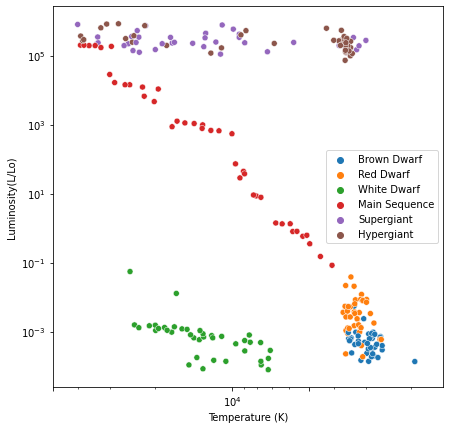

In [6]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)

plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

In [7]:
new_df_stars = df_stars.drop(["Star color", "Spectral Class", "Star type"], axis=1)

In [8]:
new_df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06
...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93
236,30839,834042.000000,1194.0000,-10.63
237,8829,537493.000000,1423.0000,-10.73
238,9235,404940.000000,1112.0000,-11.23


In [9]:
X_array = np.array(new_df_stars)

In [10]:
# rescaling of the units
def center_values (series: np.ndarray) -> np.ndarray:
    where_nan = np.isnan(series)
    series[where_nan] = np.nanmean(series)
    shifted_series = series - series.mean()
    centered_series = shifted_series / shifted_series.std()
    centered_series[where_nan] = np.nan
    return centered_series

X_cent = center_values(X_array)

In [11]:
from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit_transform(new_df_stars)
X = StandardScaler().fit_transform(X_cent)

In [12]:
new_df_stars = df_stars.drop(["Star color", "Spectral Class"], axis=1)

In [13]:
n_components=2
pca = PCA(n_components=n_components) # n_components can be optionally set
pca.fit(X) 

eigenvalues = pca.transform(X) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct
pca_comp = np.vstack([mean, pca.components_]) # Add the mean to the components
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

(240, 2)
(2, 4)


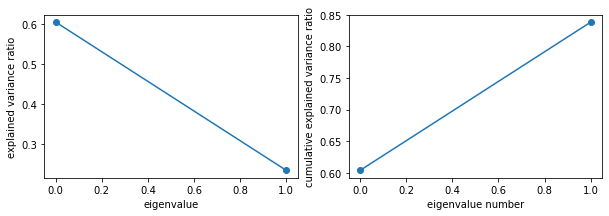

In [14]:
# Plot the results
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(np.arange(n_components), evals)
ax.scatter(np.arange(n_components), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(np.arange(n_components), evals.cumsum())
ax.scatter(np.arange(n_components), evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

In [15]:
reduced_df = pd.DataFrame(data=eigenvalues, columns=['Principal Component 1', 'Principal Component 2'])
final_df = pd.concat([reduced_df, new_df_stars[['Star type']]], axis=1)

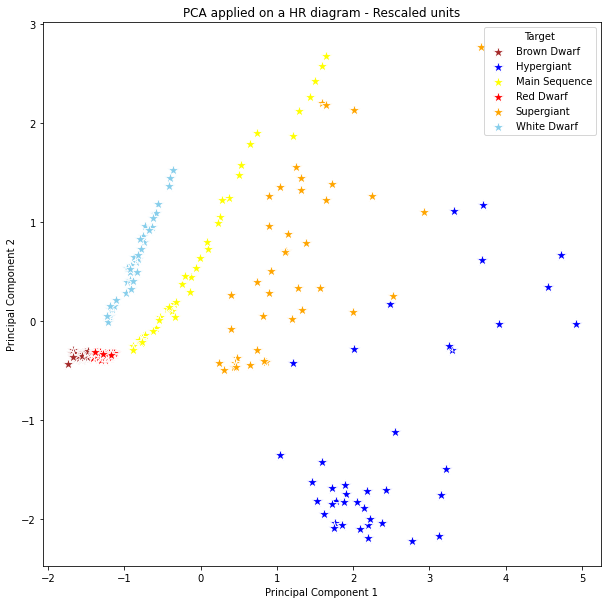

In [16]:
plt.figure(figsize=(10, 10)) 
targets = list(set(final_df['Star type'])) 
targets_name = ['Brown Dwarf', 'Hypergiant', 'Main Sequence', 'Red Dwarf', 'Supergiant', 'White Dwarf'] 
colors = ['brown', 'blue', 'yellow', 'red', 'orange', 'skyblue'] 

for target, color in zip(targets, colors):
    idx = final_df['Star type'] == target
    # change a bit the scale of the points and the colors
    plt.scatter(final_df.loc[idx, 'Principal Component 1'], final_df.loc[idx, 'Principal Component 2'], c=color, marker='*',s=150, edgecolor='w')

plt.legend(targets_name, title="Target", loc='upper right')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA applied on a HR diagram - Rescaled units')
plt.show()

In [17]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0]))
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1]))

The first component explains 0.604 of the variance in the data.
The second component explains 0.235 of the variance in the data.


Some clustering

In [34]:
X_data = np.array(final_df)

C:\Users\loren\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


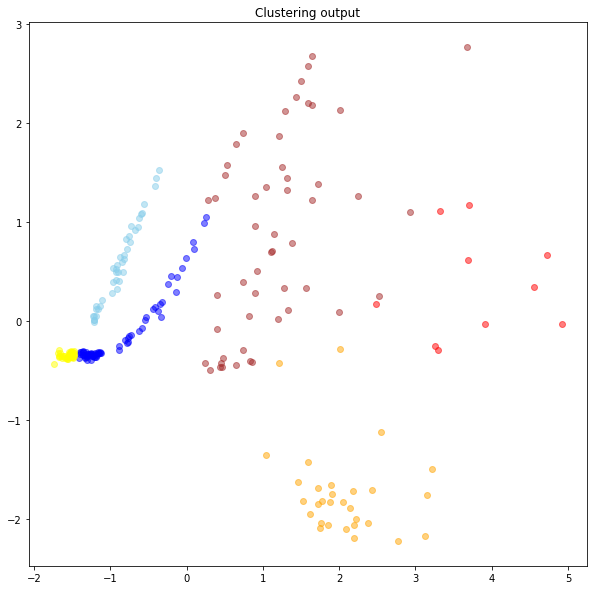

In [43]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

clf = KMeans(n_clusters=6) #Try 2 clusters to start with
clf.fit(X_data)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X_data) #labels for each of the points

# plot the data color-coded by cluster id
plt.figure(figsize=(10, 10)) 
for ii in range(6):
    plt.scatter(X_data[labels==ii,0], X_data[labels==ii,1], 
                color=colors[ii],alpha=0.5)

#plt.loglog()
plt.title('Clustering output');

Text(0, 0.5, 'Eigenvalue 2')

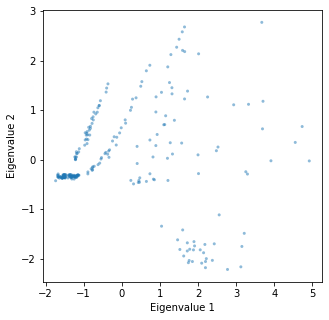

In [46]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.scatter(X_data[:,0], X_data[:,1], 
            marker=".", color='C0', 
            alpha=0.5, edgecolors='None')
ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

In [48]:
n_clusters = 6
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters, n_init='auto')
clf.fit(scaler.fit_transform(X_data))

C:\Users\loren\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

ValueError: X has 2 features, but StandardScaler is expecting 3 features as input.

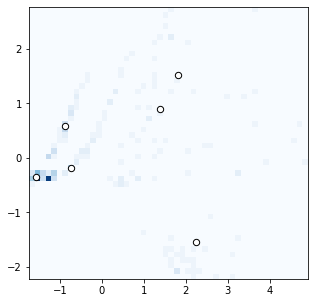

In [52]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_data[:,0], X_data[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

In [19]:
# run a classification algorithm